# End-to-end multiclass Dog breed classification

this notebook builds an end to end multiclass image classifier using tensorflow 2.0 and tensorflow hub

## 1. problems

Identifying the breed of dog given an image of a dog.

when iam sitting at a cafe and i take a photo of a doog, I want to know what breed of dog it is.

## 2. Data

the data we are using is from kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/leaderboard

## 3. Evaluation

The evalution is a file with prediction probabilities for each dog breed of each test image.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. features

some information about the data
* we are dealing with images (unstructured data) so its probabily best we use dep learning/transfer learning.
* there are 120 breed of dogs (this means there are 120 different classes).
* there are around 10,000+ images in the traing set ( these images have labels).
* there are around 10,000+ images in the test set (these images have no labels, because we will want to predict them).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np

In [5]:
#Unzip the upload data into google drive
#!unzip "/content/drive/MyDrive/data/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/data/Dog Vision/"

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

### get our workspace ready

* import TensorFlow 2.x ✅
* import TensorFlow hub ✅
* make sure we are using a GPU ✅

# Get our workspace ready

In [7]:
#import necessory tools
#import tensorflow into the colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:",tf.__version__)
print("TF hub version",hub.__version__)

#check for gpu availability
print("GPU", "available (YESSSS!)"if tf.config.list_physical_devices("GPU") else "not avaiable :(")

TF version: 2.15.0
TF hub version 0.16.1
GPU not avaiable :(


## getting our data ready (turing into tensors)

with all machine learning models, our datat has to be in numerical format. so thats what we will be doing first. Turning our images into Tensors (numerical representations).

lets start by accessing our data and check out the labels

In [ ]:
!pip install pandas

In [12]:
# checking the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/data/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
pip install matplotlib

<Axes: xlabel='breed'>

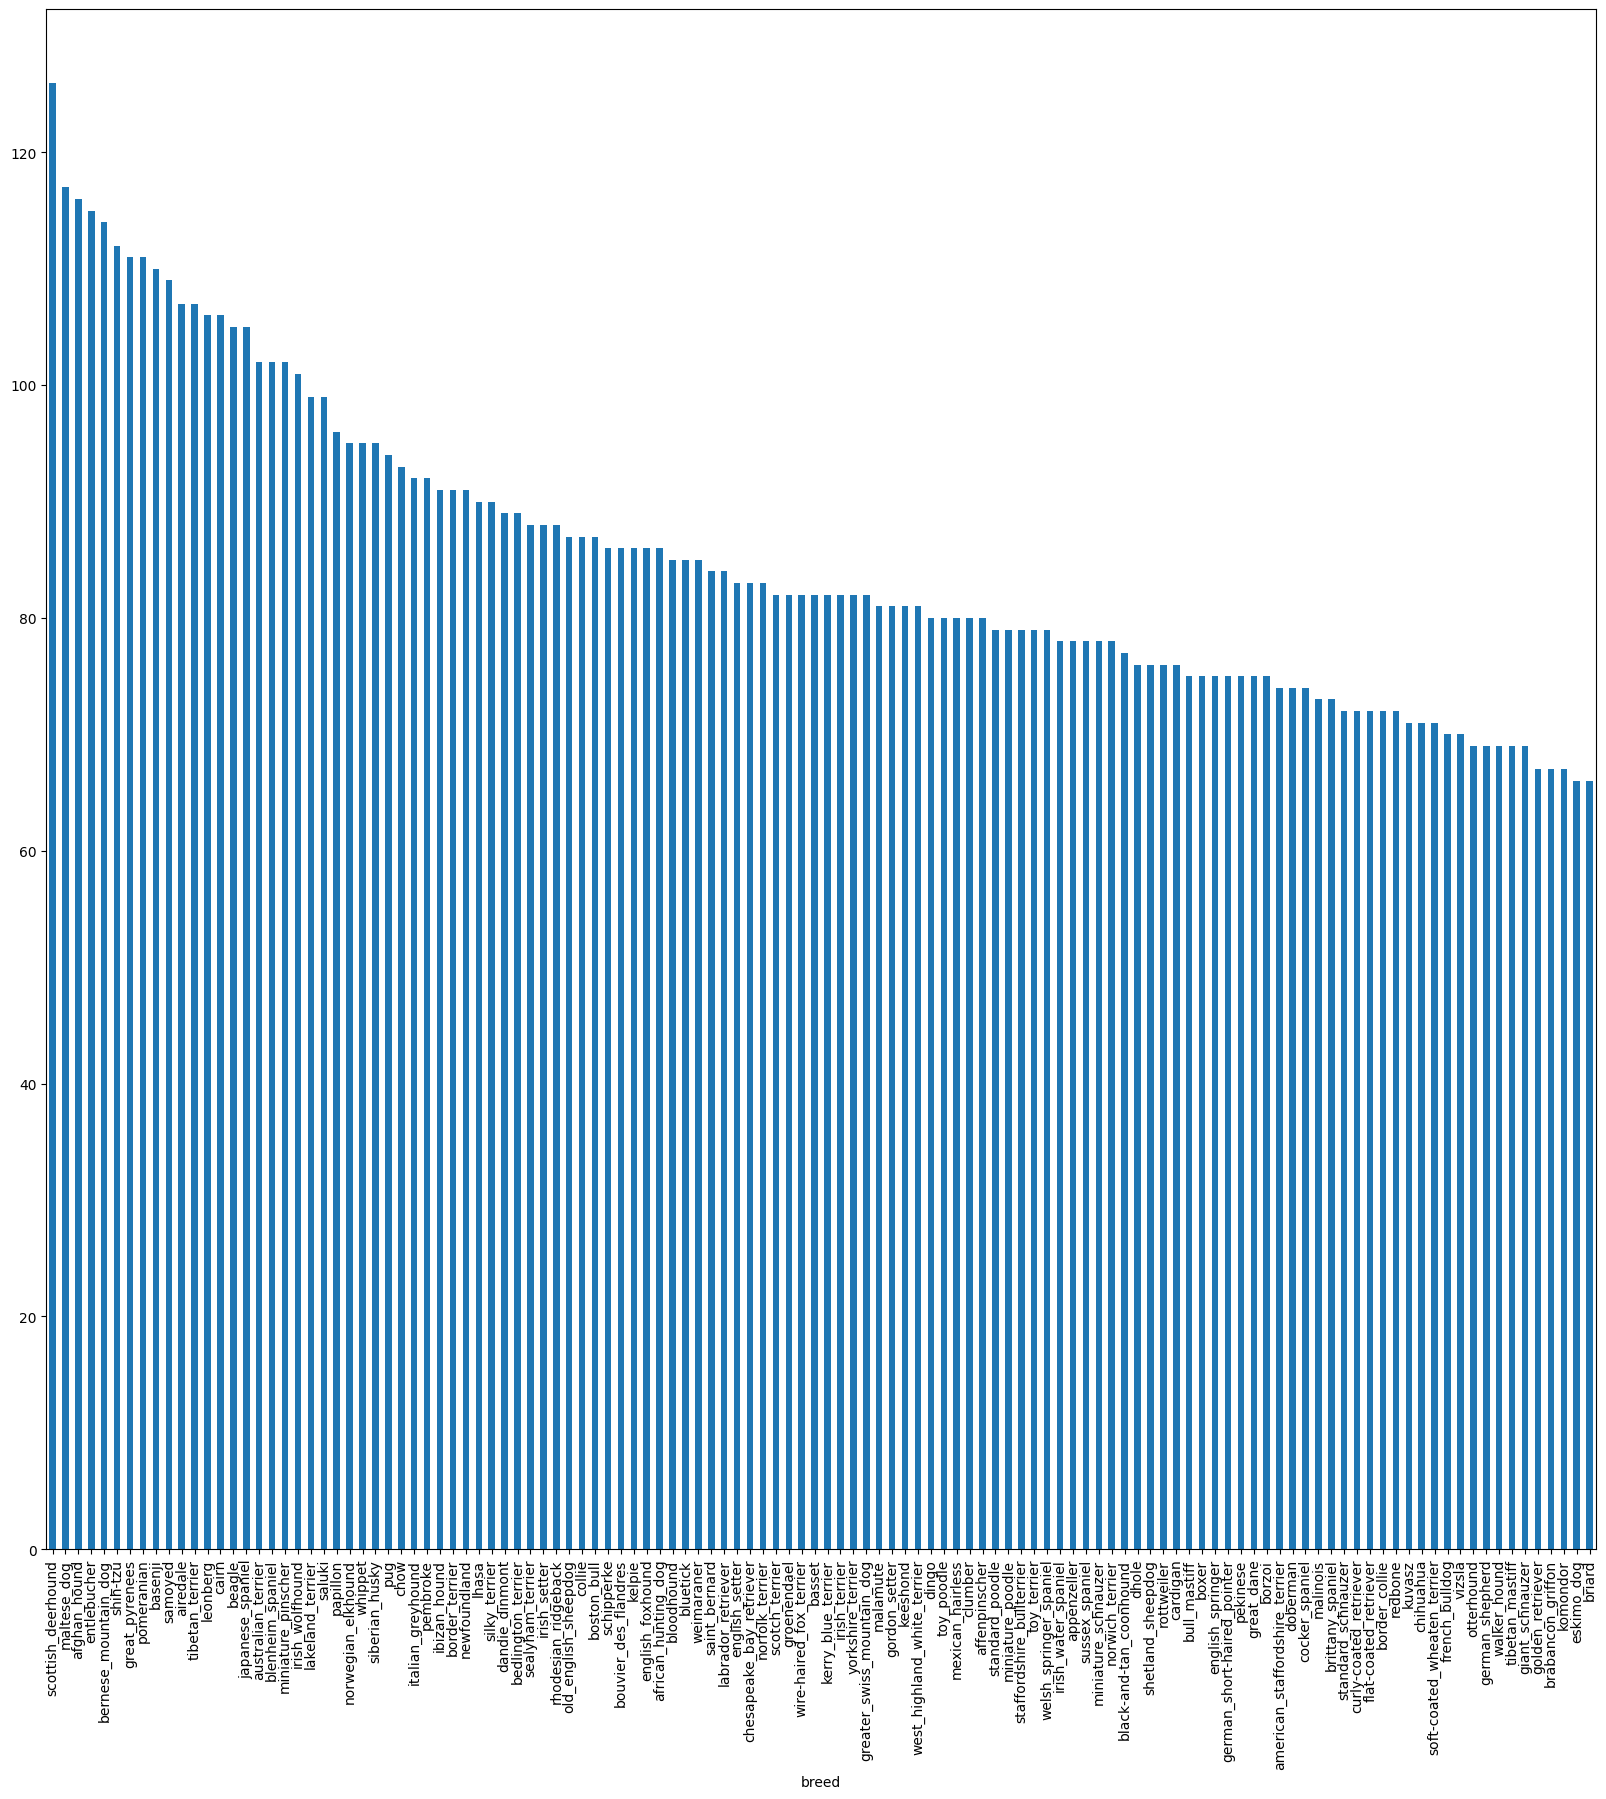

In [14]:
#how many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,20))

In [15]:
labels_csv["breed"].value_counts().median()

82.0

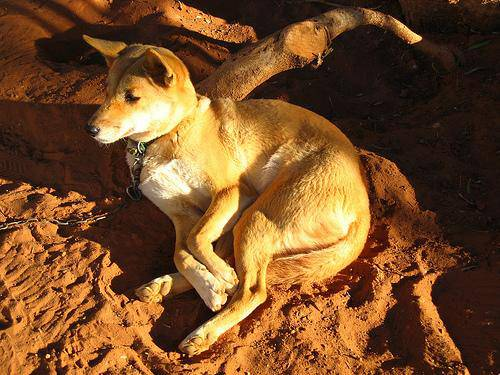

In [16]:
#lets view an image

from IPython.display import Image
Image("/content/drive/MyDrive/data/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### geting images and their labels

lets get a list of all of our image file pathnames.

In [17]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [18]:
# create a pathnames from image ID's
filenames=["/content/drive/MyDrive/data/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
len(filenames)

10222

In [19]:
import os
l=os.listdir("/content/drive/MyDrive/data/Dog Vision/train/")
len(l)


10222

In [20]:
# check weather number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/data/Dog Vision/train/"))==len(filenames):
  print("filesnames match actual amount of files!! processd.")

else:
  print("Filenames donot match actual amount of files, check the target directory.")

filesnames match actual amount of files!! processd.


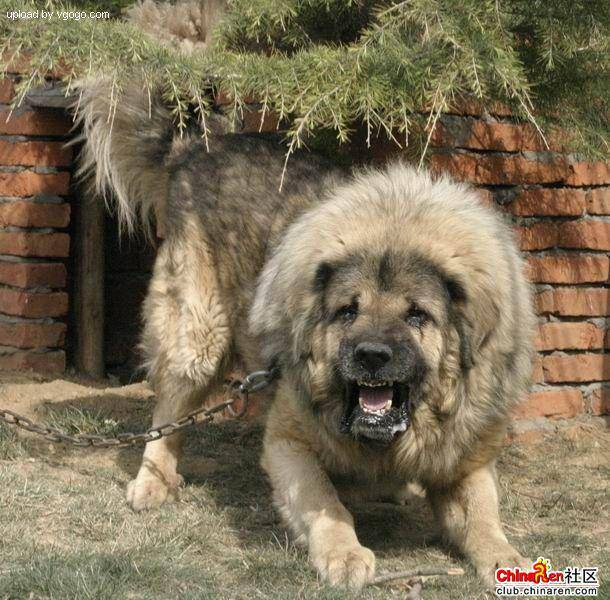

In [21]:
# one moere check
Image(filenames[9000])

In [22]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have now got our training image filepaths in a list, lets prepare our labels.

In [23]:
import numpy as np
labels=labels_csv["breed"]
labels=np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [24]:
len(labels)

10222

In [25]:
# see if number of labels matches the number of file names
if len(labels)== len(filenames):
    print("number of labels matches number of filenames!")
else:
    print("number of labels does not match number of filenames, check data directories!")

number of labels matches number of filenames!


In [26]:
# find the unique label values
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [39]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [40]:
# turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [41]:
# turn every label into boolean array
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [42]:
len(boolean_labels)

10222

In [43]:
# example truning boolean array into integers
print(labels[0])#original label
print(np.where(unique_breeds==labels[0]))#index where label occurs
print(boolean_labels[0].argmax())# index where label occurs in boolean array
print(boolean_labels[0].astype(int))#there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [44]:
filenames[:10]

['/content/drive/MyDrive/data/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/data/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### creating our own validation set

Since the dataset from kaggle doesnt come with a validation set, we are going to create our own.

In [45]:
# setup x and y variables
X=filenames
y=boolean_labels

In [46]:
len(filenames)

10222

In [47]:
len(X)

10222

# we are going to start off experimenting with ~1000 images and increase as needed

In [48]:
#set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000,steps:1000}

In [49]:
!pip install scikit-learn

In [50]:
#lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

#split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val=train_test_split(X[:NUM_IMAGES],
                                                y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [51]:
#lets have a geez at the trainijng data
X_train[:5], y_train[:5]

(['/content/drive/MyDrive/data/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/data/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/data/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/data/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/data/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fa

## preprocessing images (turing images into tensors)

to preprocess our images into Tensor we are going to wite a function which does a few things:

1. take an image filepath as imput
2. use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) intoi tensors
4. normailze our image (convert color channel values from 0-255 to 0-1)
5. resize the image to be a shape of (224, 224)
6. return the modified image

In [52]:
# convert an image to numpy array
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [53]:
image.min()

0

In [54]:
#turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we have seen what image is like in a tensor

1. take an image filepath as imput
2. use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) intoi tensors
4. resize the image to be a shape of (224, 224)
5. return the modified image

In [55]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

# turing our data into batches


why turn our data into batches

lets say your trying to process 10000 images in one go... they all might not fit into memory.

so thats why we do abput 32 (batch size ) images at a time ( you can manually adjust the batch size if you need be)

in order to use Tensorfloe effectively we need our data in the form of tensor tuples which looks like this:
`(image, label)`.


In [56]:
# create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):

    """
    Takes an image file path name and the assosicated label,
    procresses the image and returns a tuple of (image, label).
    """
    image=process_image(image_path)
    return image, label


In [57]:
#demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

now we have got a way to turn our data into tuples of tensors in the form : (image, label), lets make a function to turn all of our data (X and y) into batches

In [58]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [59]:
# create training anmd validation data batches
train_data= create_data_batches(X_train, y_train)
val_data=create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [60]:
#check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### visualizing data batches

our data is now is batched however these can be a little hard to understand/comprehend, lets visualize them!!

In [61]:
import matplotlib.pyplot as plt

#create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Display a plt of 25 images anf their labels from a data batch

    """
    #setup the fig
    plt.figure(figsize=(10,10))
    #loop through 25 (for displaying 25 images)
    for i in range(25):
        #create subplots (5 rows and 5 columns)
        ax=plt.subplot(5,5,i+1)
        #display an image
        plt.imshow(images[i])
        # add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # turn the gid lines off
        plt.axis("off")

In [62]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

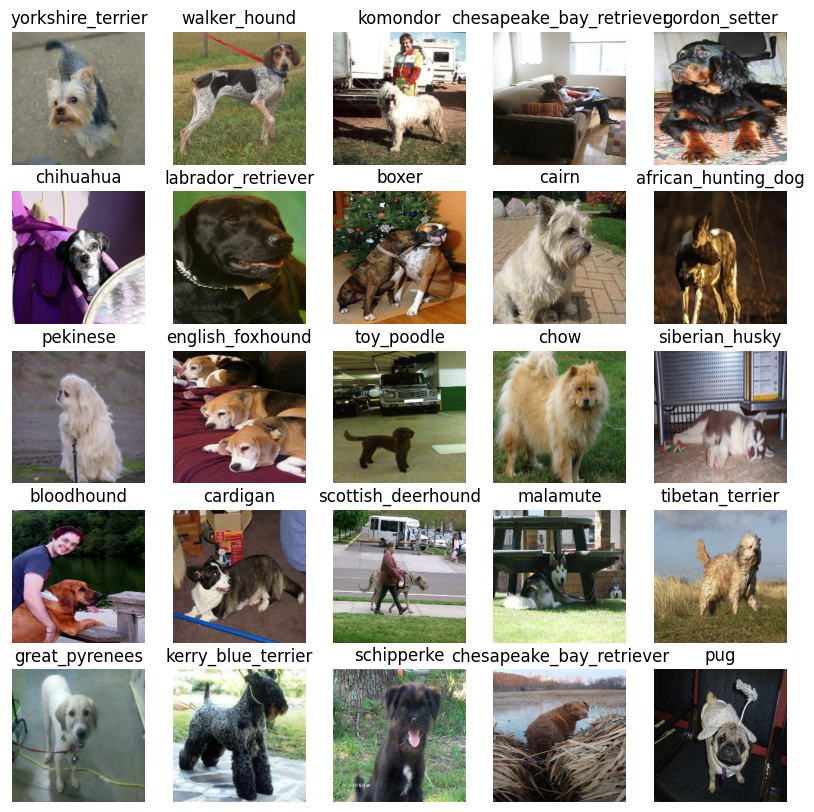

In [63]:
#now lets visualize the data in a training batch
train_images, train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

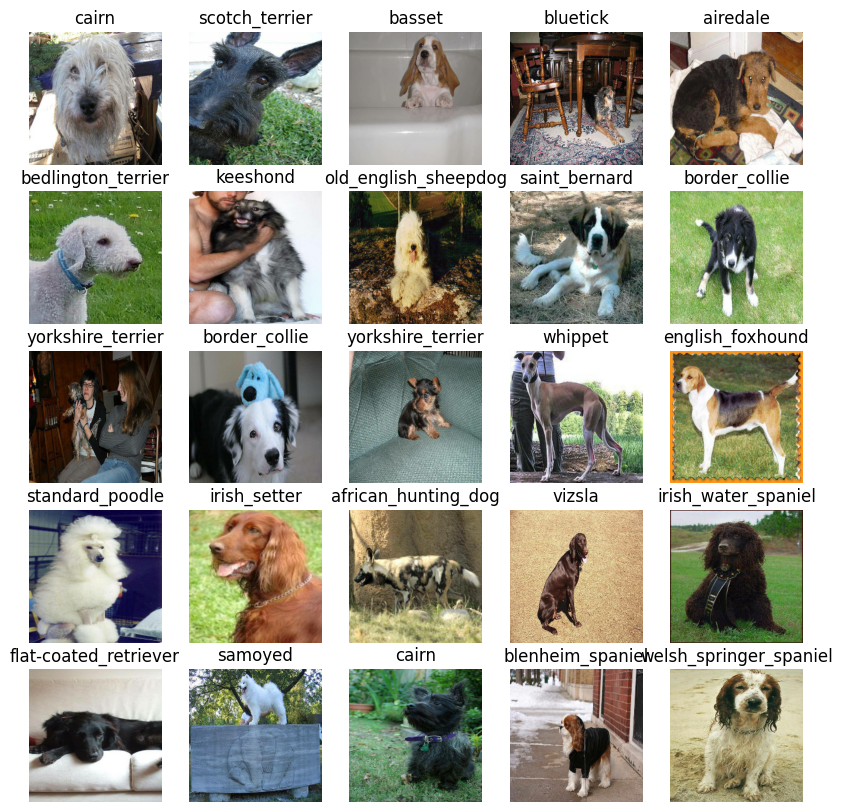

In [66]:
# now lets visualize our validation set
val_images, val_labels= next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## building a model


before we build a model, there are few things we need to define:
* the input shape (our images shape in the form of tensors) to our models.
* the output shape (image labels, in the form of tensors) of our model.
* the url of the model we want to use.

In [67]:
#setup input shape to the model
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3] # batch, heigth, width, color cahnnels

#setup output shape of our model
OUTPUT_SHAPE= len(unique_breeds)

#setup model url from tensorflow hub

MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we have got inputs and outpys and model ready to go.
lets put them together into keras deep learning model!

knowing this, lets create a fucntipn ehich
* takes teh input shape, output shape abnd model we have choosen as parameters.
* defines the layers in a keras model in sequential fashion (do this first, then this, then that).
* cimpile the model (says it should be evaluated and improved).
* builds the model (tells the model the input shape it'll be getting).
* returns the model

all of these step can be found in the tfhub.dev

In [68]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [69]:
model=create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [70]:
outputs=np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

### creating callbacks

callbacks are helper function a model can use during training to do such things as saves its progress, check its progress or stop training early if a model stops improving.

we will create two callbacks, one for tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### tensorboard callback

to setup a tensorboard callback, we need to so 3 things:
1. load the tensorboard netbook extension
2. create a tensorboard callback which is able to save logs to a directory and pass it to our models fit() function.
3. visualize our model training logs with the % tensorboard magic function ( we will do this after model training)

In [71]:
#laod tensorboard notebook extension
%load_ext tensorboard

In [72]:
import datetime

#create a function to build a tensorboard callback
def create_tensorboard_callback():
    # create a log directory for storing Tensorboard logs
    logdir=os.path.join("/content/drive/MyDrive/data/Dog Vision/logs",
                       # make it so the logs gets tracked whenever we run an experiment
                       datetime.datetime.now().strftime("%y%m%d-%H%M$S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### early stoppinng callback

Early stopping helps stop our model from overfitting bu stoppinmg training if a certain evaluation metrics stops improving

In [73]:
# create early stopping callback
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3)

# training a model( on teh subset data)

our first model is only going to train on 1000 imahes, to make sure everything is working


In [74]:
NUM_EPOCHS=100

In [75]:
# check to make sure we are still running on a gpu
print("GPU", "available (yess!!!!)" if tf.config.list_physical_devices("GPU") else "not avaiiable :(")

GPU not avaiiable :(


lets create a function which trains a model.

* create a model using `create_model()`
* setup a tensorboard callback using `create_tensorboard_callback()`
* call the fit () function on our model passimh it the training data, validation data, numbers of epoichs to train for (NUM_EPOCHS) and teh callback we did like to use
* return the model

In [76]:
# build a function to train and return a trained model
def train_model():
    """
    Train a given model adn return the trained version.
    """
    # create a model
    model=create_model()
    # create new tensorboard session everytime we train a model
    tensorboard=create_tensorboard_callback()

    #fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=val_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])
    # return the fitted model
    return model

In [ ]:
# fit the model to the data
model=train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 19s 317ms/step - loss: 4.5206 - accuracy: 0.0950 - val_loss: 3.5310 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 8s 287ms/step - loss: 1.6119 - accuracy: 0.6850 - val_loss: 2.2278 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 4s 144ms/step - loss: 0.5522 - accuracy: 0.9375 - val_loss: 1.7321 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 5s 206ms/step - loss: 0.2472 - accuracy: 0.9900 - val_loss: 1.5034 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 4s 152ms/step - loss: 0.1452 - accuracy: 0.9975 - val_loss: 1.4533 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 5s 211ms/step - loss: 0.0996 - accuracy: 0.9987 - val_loss: 1.4064 - val_accuracy: 0.6100
Epoch 7/100
25/25 [=============================

### checking the tensorboard logs

teh tensorboard magic function (%tensorboad) will acess the logs directoru we created earlier and visualize its contents

In [77]:
tensorboard --logdir /content/drive/MyDrive/data/Dog Vision/logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-04-03 23:23:04.225939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 23:23:04.226075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 23:23:04.229415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 23:23:05.747510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

### making and evalauting predections using a trained model

In [78]:
# make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 22s 3s/step


array([[3.8245586e-03, 2.0170819e-03, 2.8990470e-03, ..., 3.2860974e-03,
        4.8165722e-03, 8.7412522e-04],
       [4.6912652e-02, 1.9587163e-04, 2.6008589e-03, ..., 1.5973768e-03,
        1.6881652e-03, 2.9627758e-03],
       [1.8340178e-02, 1.2134999e-03, 2.5983937e-02, ..., 4.8159407e-03,
        2.5879666e-03, 2.0033245e-04],
       ...,
       [1.9159903e-03, 1.6880438e-05, 2.3862286e-03, ..., 1.3606014e-02,
        8.4792674e-03, 6.8347431e-03],
       [1.0165035e-03, 1.8358279e-03, 7.4506568e-04, ..., 4.6235774e-02,
        2.1445013e-03, 3.5475360e-03],
       [1.5648998e-02, 1.5426539e-03, 9.0306830e-03, ..., 1.9084992e-02,
        2.1635504e-03, 9.4221655e-04]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val)

200

In [ ]:
len(unique_breeds)

120

In [ ]:
np.sum(predictions[0])

0.9999999

In [ ]:
predictions[0]

array([8.5991179e-04, 4.4857738e-05, 1.4245445e-04, 1.4705459e-05,
       1.6169072e-03, 3.7893173e-05, 9.9942377e-03, 1.4448211e-04,
       1.3628144e-04, 5.9207866e-04, 3.0216665e-04, 6.9805246e-05,
       1.7465564e-04, 7.6521937e-05, 8.7639011e-05, 2.0146999e-04,
       3.3130036e-05, 2.8044257e-01, 9.6100503e-06, 2.6496267e-05,
       4.1145738e-04, 1.8059179e-04, 1.1906980e-05, 8.6750090e-04,
       3.1041152e-05, 1.1379380e-04, 1.9165942e-01, 4.0592156e-05,
       4.3772126e-04, 1.9820286e-04, 4.3073444e-05, 1.6643568e-03,
       4.9261580e-04, 1.1304848e-05, 6.4623295e-05, 6.9938153e-03,
       7.0863448e-06, 8.4346422e-05, 4.9981514e-05, 1.7608634e-04,
       4.3003570e-04, 9.0918693e-05, 4.1963469e-04, 5.3455169e-05,
       1.8295479e-05, 1.4283683e-04, 1.1637647e-05, 2.0269249e-04,
       3.3716569e-04, 1.4839917e-04, 3.7208054e-05, 7.5703894e-05,
       1.6690951e-04, 7.9101585e-05, 9.7664291e-05, 1.6375394e-05,
       2.4915760e-05, 2.4874259e-03, 6.2808751e-05, 6.3592628e

In [ ]:
# first prediction
index=9
print(predictions[index])
print(f"max value (probability of prediction): {np.max(predictions[0])}")
print(f"sum: {np.sum(predictions[index])}")
print(f"max index: {np.argmax(predictions[index])}")
print(f"predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.31813004e-04 1.83203409e-03 3.18144121e-05 6.76508716e-06
 2.45511904e-03 5.57482429e-03 8.55042425e-04 8.69001204e-04
 5.96460814e-06 7.50445470e-04 4.14614187e-04 1.02817155e-02
 2.57108786e-05 1.83641663e-04 6.82925107e-04 4.31481429e-04
 9.63401329e-03 2.02465264e-04 1.02632388e-03 7.16278097e-03
 4.15982613e-05 1.86893114e-04 5.62250862e-05 1.20061822e-03
 1.08034723e-03 4.84618708e-04 7.19069503e-05 2.47862120e-03
 3.80621990e-04 3.80920828e-04 5.95572114e-04 3.86105035e-04
 1.37721666e-03 7.67348111e-01 1.71887717e-04 2.49123434e-04
 6.90555607e-04 3.60943144e-04 3.31740710e-03 6.84202823e-05
 1.91138955e-04 2.68883014e-04 1.35502024e-02 1.26086653e-03
 2.69633462e-03 2.23717707e-05 1.78917937e-04 2.38085377e-05
 9.35287171e-05 9.79417469e-04 2.84949292e-05 2.17993773e-04
 4.60754288e-03 1.06906795e-04 7.85409193e-03 2.38969966e-04
 5.89369622e-04 7.23524863e-05 5.65811584e-04 2.69368989e-03
 1.34376578e-05 7.92117976e-03 3.37020640e-04 7.06408697e-04
 1.60779178e-04 3.018272

In [ ]:
unique_breeds[39]

'english_foxhound'

having the above functionality is great but we want to be able to do it at scale.

and it would be even better if we could see the image the predictions is being made on !

**Note:** predictions probaility are also known as  confidence levels

In [79]:
# turning predictions probabilities into their respective label( easier to understand)
def get_pred_label(prediction_probabilities):
    """
    turns an array of predictions probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# get  a predicted label based on an array of prediction probabilities
pred_label=get_pred_label(predictions[81])
pred_label

'affenpinscher'

now science our validation data is still in a batch dataset, we will have to unbatchify it ti make predictions on the validation images and then compare those predictions to the validation labels( truth labels)

In [80]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [81]:
# create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Take a batch dataset of (image,labe) tensors and returns separate arrays of images and labels
    """
    images=[]
    labels=[]
    #loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])

    return images, labels


# unbatchify the validation data
val_images, val_labels=unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [82]:
images_=[]
labels_=[]

# loop through unbatch data
for image, label in val_data.unbatch().as_numpy_iterator():
    print(image)
    print(label)

Streaming output truncated to the last 5000 lines.

 [[0.25513488 0.2201559  0.19254734]
  [0.25818455 0.22320555 0.19559701]
  [0.28897905 0.25400007 0.22639151]
  ...
  [0.1393125  0.11606315 0.06900433]
  [0.12893534 0.11324905 0.06619023]
  [0.1432429  0.12755662 0.08441938]]

 ...

 [[0.3310362  0.49429712 0.192543  ]
  [0.33433145 0.47802895 0.20559186]
  [0.30533677 0.42943233 0.1872521 ]
  ...
  [0.46766642 0.56528556 0.3105236 ]
  [0.46012917 0.5464037  0.29220206]
  [0.43060845 0.51802564 0.25969562]]

 [[0.23758024 0.40422344 0.09904134]
  [0.29779172 0.44837025 0.16837995]
  [0.34402    0.46993035 0.22217126]
  ...
  [0.4661402  0.56106675 0.314582  ]
  [0.47245407 0.5587286  0.3078179 ]
  [0.44306177 0.5293363  0.27553126]]

 [[0.2004445  0.37246928 0.06589444]
  [0.26245335 0.41708085 0.13304158]
  [0.34722233 0.47338593 0.21853644]
  ...
  [0.43430075 0.52813834 0.28500107]
  [0.4386964  0.5249709  0.2753912 ]
  [0.43219256 0.51846707 0.26725814]]]
[False False False Fal

NO we have got ways to get :
* prediction labels
* validation labels (truth labels)
* validation images


lets make some function to make these all a bit more visaulize.

we will create a function which:
* take an array of prediction probabilities, an array of truth labels and an array of images and intergers.
* convert the prediction probabilities to predicted label
* plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [83]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    view the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image= prediction_probabilities[n], labels[n], images[n]

    # get the pred label
    pred_label=get_pred_label(pred_prob)

    # plot image and remoe ticks
    plt. imshow(image)
    plt.xticks([])
    plt.yticks([])

    #change the color pf the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color="green"

    else:
        color="red"

    #change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}%{}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                     color=color)


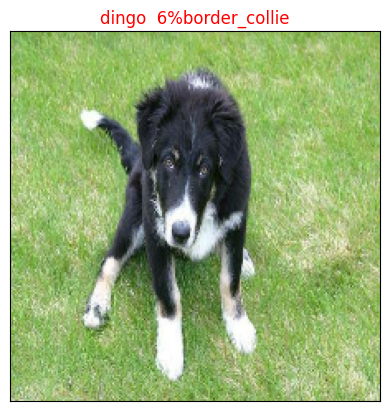

In [84]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images,
         n=9)

now we have got one function to visualize our model top predictions, lets make another to view our models top 10 predcitions

this function will :
* take an imput of prediction probabilies array and a ground truth array and an interger
* find the prediction using "get_pred_label"
* find the top 10:
   * predictions probabilities indexes
   * prediction probabities values
   * prediction label
* plot the top 10 prediction probability values and labels, coloring the tru label green
  

In [85]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    plus the top 10 highest prediction confidence along with the truth label for sample n.
    """
    pred_prob, true_label= prediction_probabilities[n], labels[n]

    #get the prediction label
    pred_label=get_pred_label(pred_prob)

    # find the top 10 prediction confidence indexes
    top_10_pred_indexes=pred_prob.argsort()[-10:][::-1]
    # find the top 10 prediction confidence values
    top_10_pred_values=pred_prob[top_10_pred_indexes]
    #find the top 10 prediction labels
    top_10_pred_labels=unique_breeds[top_10_pred_indexes]

    #setup plot
    top_plot=plt.bar(np.arange(len(top_10_pred_labels)),
                    top_10_pred_values,
                    color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation="vertical")

    # cahnge the color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")

    else:
        pass

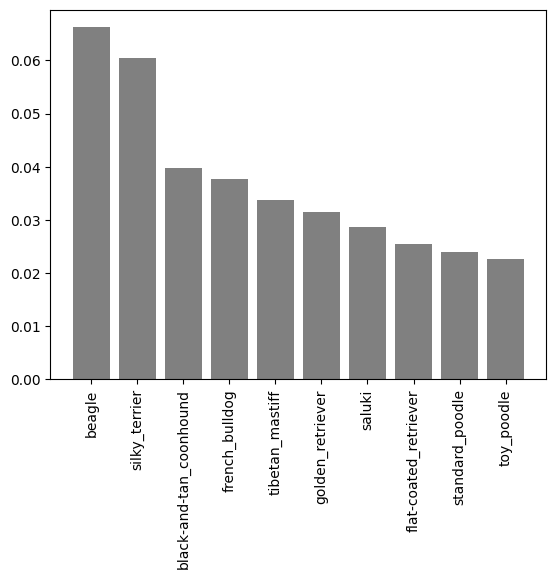

In [86]:
plot_pred_conf(prediction_probabilities=predictions,
              labels=val_labels,
              n=42)

now we have got some functions to help us visualize our predictions and evaluate our model, lets check out a few

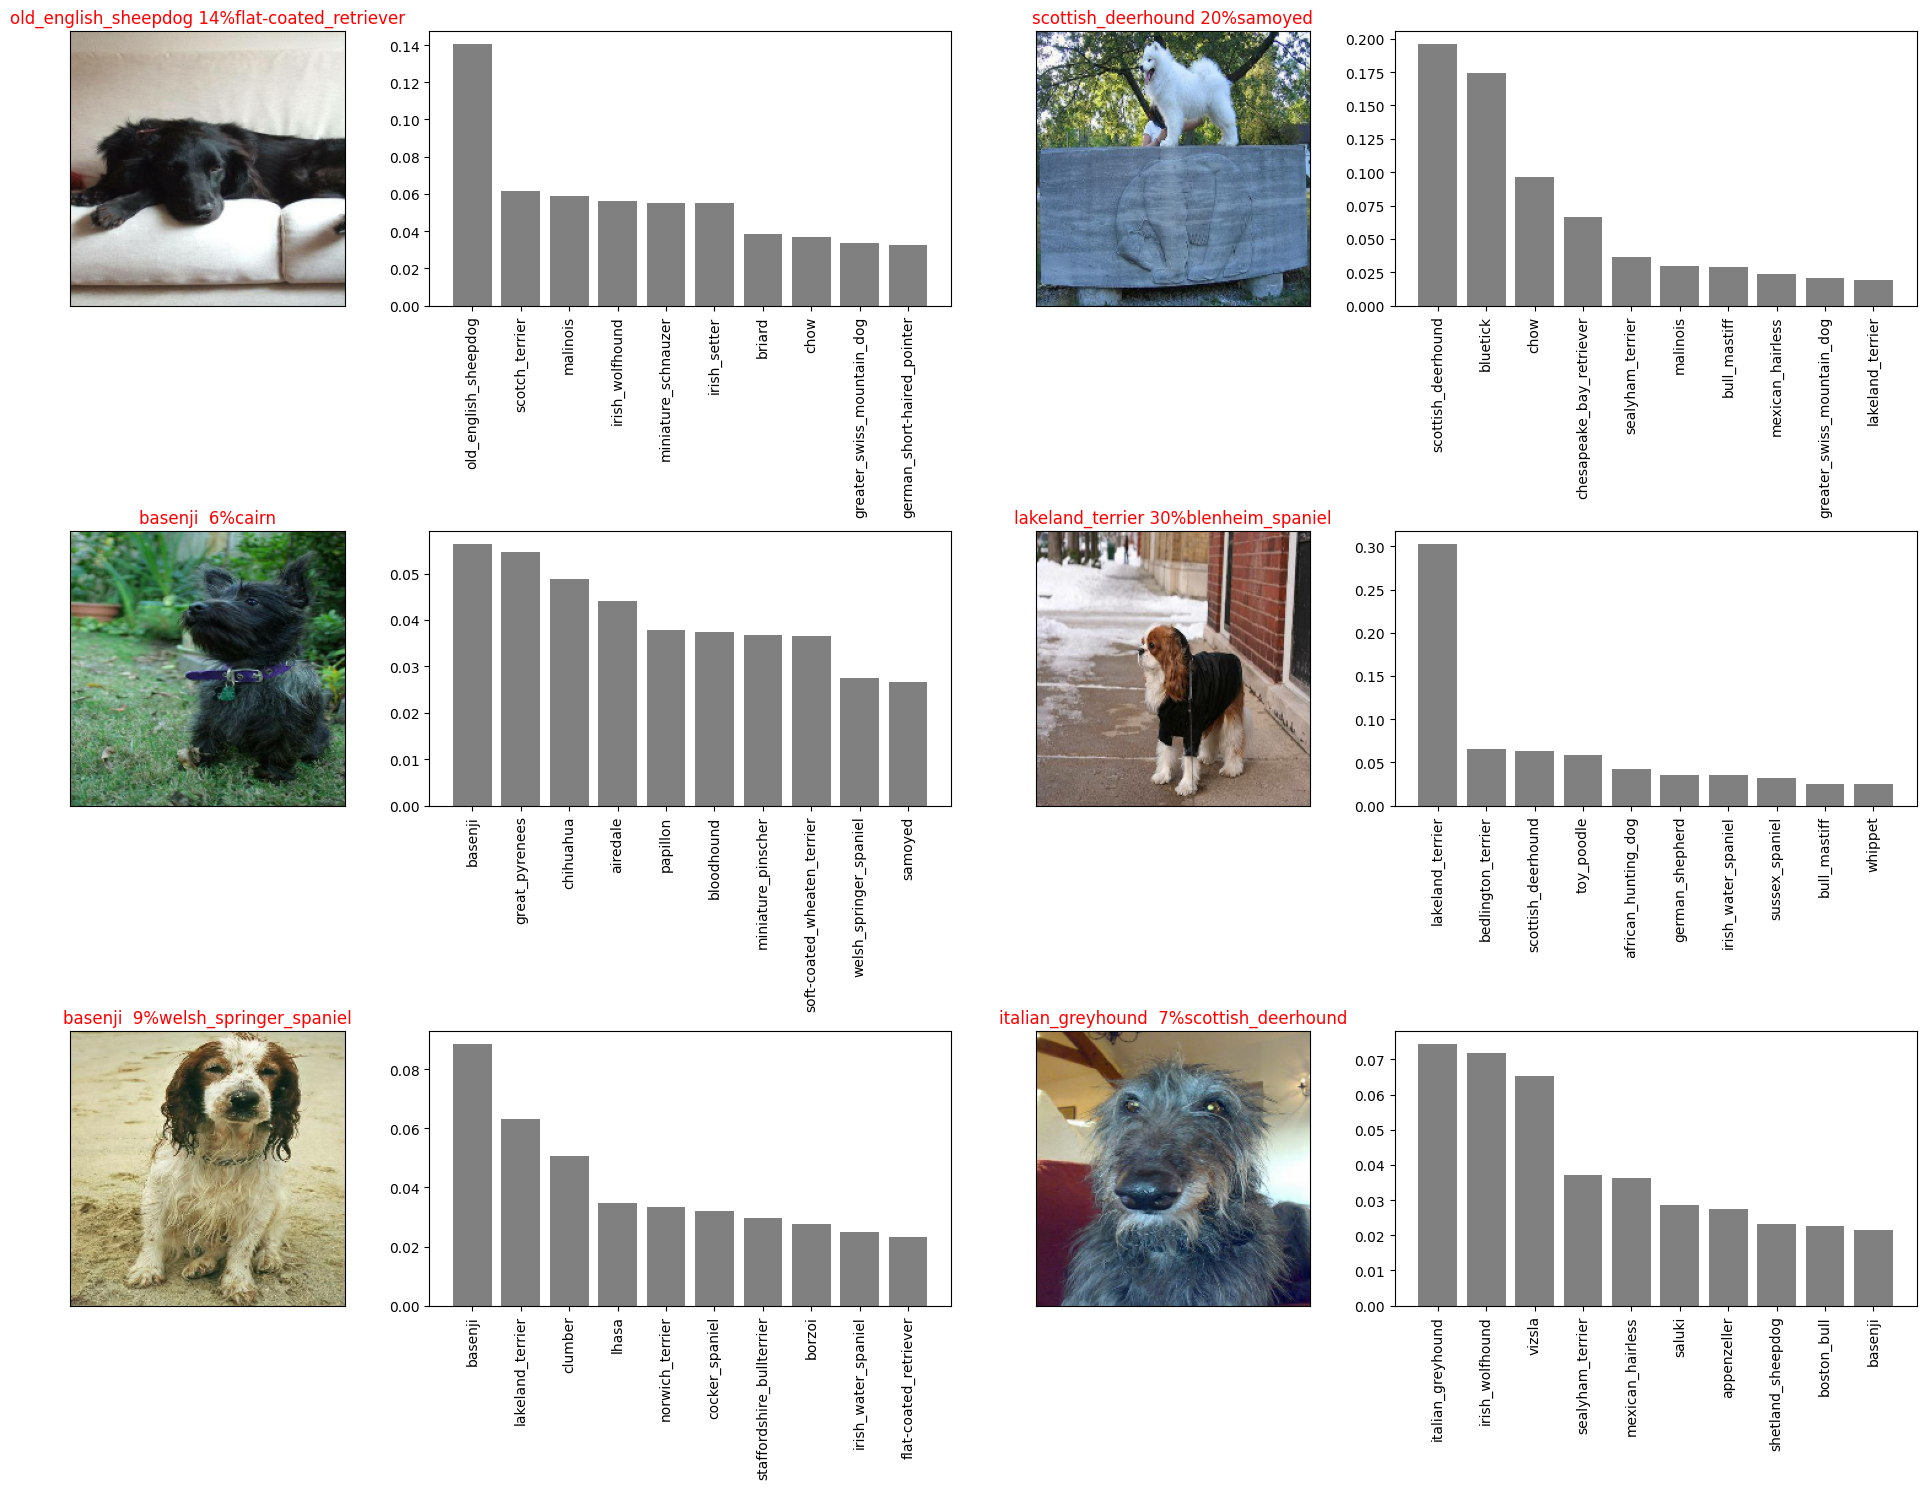

In [87]:
# lets check out a few predictions and their different values
i_multiplier=20
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                  labels=val_labels,
                  n=i+i_multiplier)
    plt.tight_layout(h_pad=1.0)
plt.show()

**challenge:** how would you create a confusion matrix aith our models predictions and tru labels?

### saving and reloading a trained model

In [88]:
# create a fucntion to save a model
def save_model(model, suffix=None):
    """
    saves a given model in a models directory and appends a suffix (string).
    """
    #create a model directory pathname with current time
    modeldir=os.path.join("/content/drive/MyDrive/data/Dog Vision/model",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path=modeldir + "-"+suffix+".h5"# save format of model
    print(f"saving model to :{model_path}...")
    model.save(model_path)
    return model_path

In [89]:
#create a fuction to load a trained model
def load_model(model_path):
    """
    loads a saved model from a specified path
    """
    print(f"loading saved model from : {model_path}")
    model=tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer":hub.KerasLayer})
    return model

now we have got functions to save and load a trained model, lets nmake sure they work!

In [ ]:
# save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv3-Adam")

saving model to :/content/drive/MyDrive/data/Dog Vision/model/20240403-205636-1000-images-mobilenetv3-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/data/Dog Vision/model/20240403-205636-1000-images-mobilenetv3-Adam.h5'

In [90]:
# load a trained model
loaded_1000_image_model=load_model("/content/drive/MyDrive/data/Dog Vision/model/20240403-205636-1000-images-mobilenetv3-Adam.h5")

loading saved model from : /content/drive/MyDrive/data/Dog Vision/model/20240403-205636-1000-images-mobilenetv3-Adam.h5


In [91]:
# evauate teh pre save model
model.evaluate(val_data)

7/7 [==============================] - 15s 2s/step - loss: 5.9296 - accuracy: 0.0050


[5.929625034332275, 0.004999999888241291]

In [92]:
# evalaute the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 14s 2s/step - loss: 1.2521 - accuracy: 0.6600


[1.2521244287490845, 0.6600000262260437]

# traing a big dog model ( on the full data)

In [93]:
len(X), len(y)

(10222, 10222)

In [94]:
# create a data batch with the full data set

full_data= create_data_batches(X, y)

Creating training data batches...


In [95]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [96]:
# create a model for full model
full_model=create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [97]:
# create full model callbacks
full_model_tensorboard= create_tensorboard_callback()
# no validation set when training on all the data, so we cant monitor validation accuracy
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

**note:** running the cell below will take a little while (maybe up to 30 mins for the first epoch) because the gpu we are using in the runtime has to load all of the images into memory

In [ ]:
#fit the full modol to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 51s 139ms/step - loss: 1.3354 - accuracy: 0.6734
Epoch 2/100
320/320 [==============================] - 44s 137ms/step - loss: 0.3969 - accuracy: 0.8843
Epoch 3/100
320/320 [==============================] - 43s 134ms/step - loss: 0.2344 - accuracy: 0.9364
Epoch 4/100
320/320 [==============================] - 44s 138ms/step - loss: 0.1533 - accuracy: 0.9627
Epoch 5/100
320/320 [==============================] - 43s 135ms/step - loss: 0.1036 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 42s 132ms/step - loss: 0.0772 - accuracy: 0.9859
Epoch 7/100
320/320 [==============================] - 43s 134ms/step - loss: 0.0584 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 44s 136ms/step - loss: 0.0462 - accuracy: 0.9954
Epoch 9/100
320/320 [==============================] - 43s 135ms/step - loss: 0.0376 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 43s 135m

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv3-Adam")

saving model to :/content/drive/MyDrive/data/Dog Vision/model/20240403-211444-full-image-set-mobilenetv3-Adam.h5...


'/content/drive/MyDrive/data/Dog Vision/model/20240403-211444-full-image-set-mobilenetv3-Adam.h5'

In [98]:
#loading full model
loaded_full_model=load_model("/content/drive/MyDrive/data/Dog Vision/model/20240403-211444-full-image-set-mobilenetv3-Adam.h5")

loading saved model from : /content/drive/MyDrive/data/Dog Vision/model/20240403-211444-full-image-set-mobilenetv3-Adam.h5


In [99]:
len(X)

10222

## making predictions on the test dataset


since our model has beem trained on images in the form of Tensor batches to make predictions on the test data, we will have to get it into the same format.

luckily we created `create_data_batches()` earlier which can take a lsit of fileneme as imput and cover  them into tensor batchers.

to make predictions on the test data, we will:
* Get the test images filenames
* convert the filenaems into test data batches using create_data_batches() and settuing the test_data parameter to True (since the test data doesnt  have labels).
* make a predictions array by passing the test batches to the predict() method called on our model

In [100]:
# load test image filenames
test_path="/content/drive/MyDrive/data/Dog Vision/test/"
test_filenames=[test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/data/Dog Vision/test/f12b509213db8bb0a721fcd228b31f0e.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/eaba5de4287936fcab47f236d58d3f14.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/efdf443fb4a6ad5964c18d6676f36652.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/ef0209bcfab48f72f71c9d1b8648aa45.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f4e1d93f8d4f389547d69a5cd468e49d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f4fa65b062607d69c98f16cb625d5915.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f367afa19bb30234fafa16c64b3730f0.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f2c4131850c17dee485d48c2bb8a358e.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/e85d4e2707683df0e6387e19b67b873d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/ed574861296d0946948a4225e60e8d75.jpg']

In [101]:
len(test_filenames)

10357

In [102]:
test_filenames

['/content/drive/MyDrive/data/Dog Vision/test/f12b509213db8bb0a721fcd228b31f0e.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/eaba5de4287936fcab47f236d58d3f14.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/efdf443fb4a6ad5964c18d6676f36652.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/ef0209bcfab48f72f71c9d1b8648aa45.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f4e1d93f8d4f389547d69a5cd468e49d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f4fa65b062607d69c98f16cb625d5915.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f367afa19bb30234fafa16c64b3730f0.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f2c4131850c17dee485d48c2bb8a358e.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/e85d4e2707683df0e6387e19b67b873d.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/ed574861296d0946948a4225e60e8d75.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/eadffa2af96b121d7e61dcd91ab11a39.jpg',
 '/content/drive/MyDrive/data/Dog Vision/test/f586cdd98e69c6909b8

In [103]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [104]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** calling predict on our full model and passing it the test data batch will take a long time to run( aboput an ~1hr).

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 189s 583ms/step


In [ ]:
# save predictions (numpy array) to csv file (for access later)
np.savetxt("/content/drive/MyDrive/data/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [105]:
#load_predictions (numpy array) from csv file
test_predictions=np.loadtxt("/content/drive/MyDrive/data/Dog Vision/preds_array.csv", delimiter=",")

In [106]:
test_predictions[:10]

array([[1.03812427e-11, 1.01473918e-12, 1.25574932e-15, ...,
        1.18588380e-13, 3.28425509e-10, 1.04834787e-11],
       [1.16119536e-05, 1.11660563e-06, 6.51723475e-09, ...,
        1.88312924e-11, 1.01628693e-07, 2.63742317e-09],
       [2.06715461e-11, 4.48726553e-07, 3.19597184e-08, ...,
        7.75837293e-07, 9.16899542e-11, 3.03500176e-11],
       ...,
       [5.42728751e-09, 1.55418983e-10, 7.12786635e-11, ...,
        1.75493940e-12, 6.18761119e-12, 5.32215626e-11],
       [2.35566948e-11, 5.94034710e-10, 1.42472367e-10, ...,
        2.83882991e-06, 6.14862294e-09, 2.94225998e-11],
       [5.21256860e-09, 9.62138442e-12, 1.36159244e-11, ...,
        2.52744033e-13, 3.42308061e-12, 4.02946867e-08]])

In [107]:
test_predictions.shape

(10357, 120)

### preparing test dataset predictions for kaggle

looking at the kaggle sample submission, we find that it wants our models prediction probability outputs in a dataframe with ID and a column for each different dog breed.


to get the data in this format, we will
* create a panda datrafram with an ID column as well as a column for each dog breed
* add data to id column by extrating the test image ids from theri filepaths
* add date (the prediction probabilities) to each of the dog breeds columns
* export the dataframe as a csv to submit it to kaggle

In [108]:
# create a pandas dataframe with empty colums
preds_df=pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [109]:
#append test image IDs to predictions dataframe
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"]=test_ids

In [110]:
os.path.splitext(test_filenames[0])

('/content/drive/MyDrive/data/Dog Vision/test/f12b509213db8bb0a721fcd228b31f0e',
 '.jpg')

In [111]:
preds_df.head()

id affenpinscher afghan_hound  \
0  f12b509213db8bb0a721fcd228b31f0e           NaN          NaN   
1  eaba5de4287936fcab47f236d58d3f14           NaN          NaN   
2  efdf443fb4a6ad5964c18d6676f36652           NaN          NaN   
3  ef0209bcfab48f72f71c9d1b8648aa45           NaN          NaN   
4  f4e1d93f8d4f389547d69a5cd468e49d           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [112]:
# add the prediction probabilities to ech dog breed column
preds_df[list(unique_breeds)]=test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  f12b509213db8bb0a721fcd228b31f0e   1.038124e-11  1.014739e-12   
1  eaba5de4287936fcab47f236d58d3f14   1.161195e-05  1.116606e-06   
2  efdf443fb4a6ad5964c18d6676f36652   2.067155e-11  4.487266e-07   
3  ef0209bcfab48f72f71c9d1b8648aa45   4.336620e-07  7.205351e-07   
4  f4e1d93f8d4f389547d69a5cd468e49d   8.560898e-05  3.570461e-06   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.255749e-15  1.437798e-14                    2.732295e-13   
1         6.517235e-09  1.857160e-09                    2.389915e-06   
2         3.195972e-08  8.573595e-11                    5.281797e-11   
3         3.948519e-07  9.906899e-06                    1.042305e-05   
4         5.460966e-09  1.181030e-09                    1.555862e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  9.256298e-12        7.157225e-17  1.530211e-13  1.585318e-13  ...   
1  6.688056e-09        1.293339e-06  2.876882e-07  6.643964e-09  ...   
2  8.525401e-09        2.257307e-11  7.324504e-12  3.266210e-10  ...   
3  9.052470e-06        3.463474e-11  1.766551e-08  1.483577e-07  ...   
4  8.381014e-12        1.471835e-10  7.003425e-09  2.796168e-08  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  4.092027e-13  6.919363e-14  2.723480e-14  1.266028e-15  5.851197e-15   
1  1.849660e-08  8.785891e-08  9.843344e-10  2.413019e-06  3.554910e-08   
2  4.568789e-12  5.944328e-12  1.186476e-08  2.704701e-07  5.577985e-08   
3  4.092889e-07  1.326140e-09  6.099562e-07  9.095850e-10  7.311670e-08   
4  1.531512e-07  1.231163e-10  2.596590e-11  1.066697e-10  4.089011e-10   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            8.102948e-13                 1.443019e-13  1.185884e-13   
1            9.448872e-08                 3.126576e-04  1.883129e-11   
2            2.076987e-08                 1.188215e-12  7.758373e-07   
3            1.757396e-09                 3.260349e-14  1.773837e-03   
4            5.074726e-10                 5.617560e-11  5.393251e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             3.284255e-10       1.048348e-11  
1             1.016287e-07       2.637423e-09  
2             9.168995e-11       3.035002e-11  
3             9.769070e-11       5.520833e-08  
4             1.180377e-09       4.072927e-08  

[5 rows x 121 columns]

In [113]:
preds_df.to_csv("/content/drive/MyDrive/data/Dog Vision/full_model_submission_1.csv", index=False)

## making prediction on custom images

to make prediction on custum images, we will:

* get the file path pf our own images
* turn the filepaths into data batches using create_data_bathes(). and since our custom images wont have labels we set the test_data parameter to True
* pass the custom image data batch to our models predict() method
* convert the prediction output probabilities labels.
* compare the predicted labels to the custom images

In [114]:
# get custom image filepaths
custom_path="/content/drive/MyDrive/data/Dog Vision/my-dog-images/"
custom_image_paths=[custom_path + fname for fname in os.listdir(custom_path)]

In [115]:
custom_image_paths

['/content/drive/MyDrive/data/Dog Vision/my-dog-images/9f561a7b3e506bf906fd2ca185e894f1.jpg',
 '/content/drive/MyDrive/data/Dog Vision/my-dog-images/ASHH5bDmsp6wnK6mEfZdcU.jpg']

In [116]:
# turn custom images into batch datasets
custom_data=create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [117]:
# make predictions on the custom data
custom_preds=loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 729ms/step


In [118]:
custom_preds.shape

(2, 120)

In [119]:
#get custom image prediction labels
custom_preds_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

['groenendael', 'groenendael']

In [120]:
# get custom images (or unbatchify () function wont work since there arent labels....)
custom_images=[]
# loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

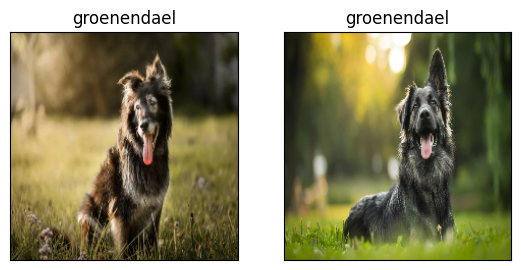

In [121]:
# check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)